In [ ]:
# pip install yfinance
# pip install Prophet

In [ ]:
import pandas as pd

from prophet import Prophet
import yfinance as yf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

import optuna
from prophet.diagnostics import cross_validation, performance_metrics
import joblib

In [92]:
day = pd.Timestamp.now().strftime("%Y-%m-%d")

In [19]:
# Example: Pull Apple (AAPL) stock data
ticker = "AAPL"

# Download historical data (daily, last 1 year)
data = yf.download(ticker, period="1y", interval="1d")

[*********************100%***********************]  1 of 1 completed


In [20]:
data.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2025-01-31,234.937424,246.077044,232.388952,246.077044,100959800
2025-02-03,226.983398,230.786206,224.683801,228.954495,73063300
2025-02-04,231.751831,232.080347,225.629512,226.226817,45067300
2025-02-05,231.423325,231.622421,227.242238,227.501062,39620300
2025-02-06,232.169952,232.747343,229.392506,230.248634,29925300


In [21]:
tickers = ["AAPL", "MSFT", "GOOG"]
data_multi = yf.download(tickers, period="10y", interval="1d")

data_multi.head()

[*********************100%***********************]  3 of 3 completed


Price           Close                             High                        \
Ticker           AAPL       GOOG       MSFT       AAPL       GOOG       MSFT   
Date                                                                           
2016-02-01  21.741968  37.320095  47.904640  21.805099  37.610917  48.237373   
2016-02-02  21.302307  37.947884  46.407360  21.654038  39.199498  47.510628   
2016-02-03  21.723932  36.076912  45.671852  21.834412  38.436711  46.748853   
2016-02-04  21.898487  35.136967  45.531742  22.063973  36.079396  46.240988   
2016-02-05  21.313614  33.924065  43.920624  21.971022  34.937464  45.531747   

Price             Low                             Open                        \
Ticker           AAPL       GOOG       MSFT       AAPL       GOOG       MSFT   
Date                                                                           
2016-02-01  21.509735  36.886848  47.720763  21.750987  37.243669  48.053496   
2016-02-02  21.257212  37.947884  46.100898  21.514247  38.932995  47.431823   
2016-02-03  21.212119  35.756814  44.883801  21.419550  38.224308  46.626268   
2016-02-04  21.578852  34.831753  44.980107  21.730735  35.871456  45.619302   
2016-02-05  21.238807  33.754336  43.395259  21.880345  34.931508  45.479209   

Price          Volume                       
Ticker           AAPL       GOOG      MSFT  
Date                                        
2016-02-01  163774000  102784000  44208500  
2016-02-02  149428800  126962000  56313800  
2016-02-03  183857200  123420000  57559800  
2016-02-04  185886800  103374000  46987100  
2016-02-05  185672400  102114000  62009000

In [22]:
df = data_multi.unstack().reset_index()

In [23]:
df.head()

,Price,Ticker,Date,0
0,Close,AAPL,2016-02-01,21.741968
1,Close,AAPL,2016-02-02,21.302307
2,Close,AAPL,2016-02-03,21.723932
3,Close,AAPL,2016-02-04,21.898487
4,Close,AAPL,2016-02-05,21.313614


In [24]:
df_close = df[df['Price'] == 'Close'].copy()

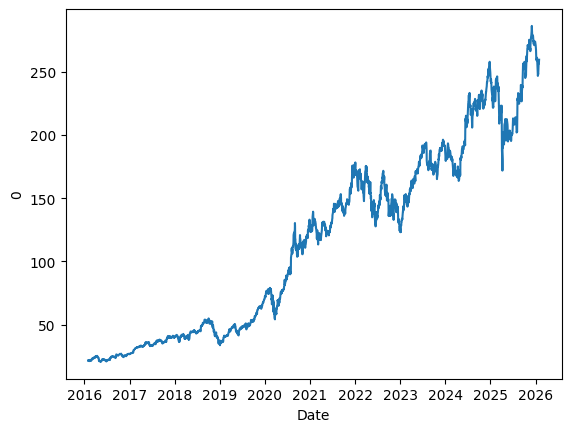

In [25]:
sns.lineplot(df[(df['Ticker'] == 'AAPL') & (df['Price'] == 'Close')],x='Date',y=0);

# Plot the different prices

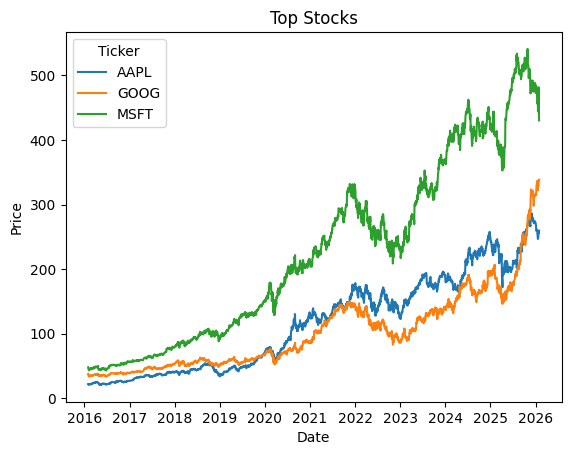

In [26]:
sns.lineplot(df_close, x='Date', y=0, hue='Ticker')
plt.ylabel('Price')
plt.title('Top Stocks');

# Plot their simple moving averages

In [27]:
# Compute 20-day SMA for each Ticker
df_close['sma_20day'] = df_close.groupby('Ticker')[0].transform(lambda x: x.rolling(20).mean())

# Now df_close already has the SMA column; no need to merge

df_close.rename(columns={0:'Close Price'},inplace=True)

df_close.head()

,Price,Ticker,Date,Close Price,sma_20day
0,Close,AAPL,2016-02-01,21.741968,NaN
1,Close,AAPL,2016-02-02,21.302307,NaN
2,Close,AAPL,2016-02-03,21.723932,NaN
3,Close,AAPL,2016-02-04,21.898487,NaN
4,Close,AAPL,2016-02-05,21.313614,NaN


In [28]:
df_close_melt = df_close.melt(id_vars=['Date','Ticker'], value_vars=['Close Price','sma_20day'],var_name='Type', value_name='Price (dollars)')
df_close_melt

,Date,Ticker,Type,Price (dollars)
0,2016-02-01,AAPL,Close Price,21.741968
1,2016-02-02,AAPL,Close Price,21.302307
2,2016-02-03,AAPL,Close Price,21.723932
3,2016-02-04,AAPL,Close Price,21.898487
4,2016-02-05,AAPL,Close Price,21.313614
...,...,...,...,...
15085,2026-01-26,MSFT,sma_20day,471.041000
15086,2026-01-27,MSFT,sma_20day,470.684500
15087,2026-01-28,MSFT,sma_20day,470.411000
15088,2026-01-29,MSFT,sma_20day,467.712000


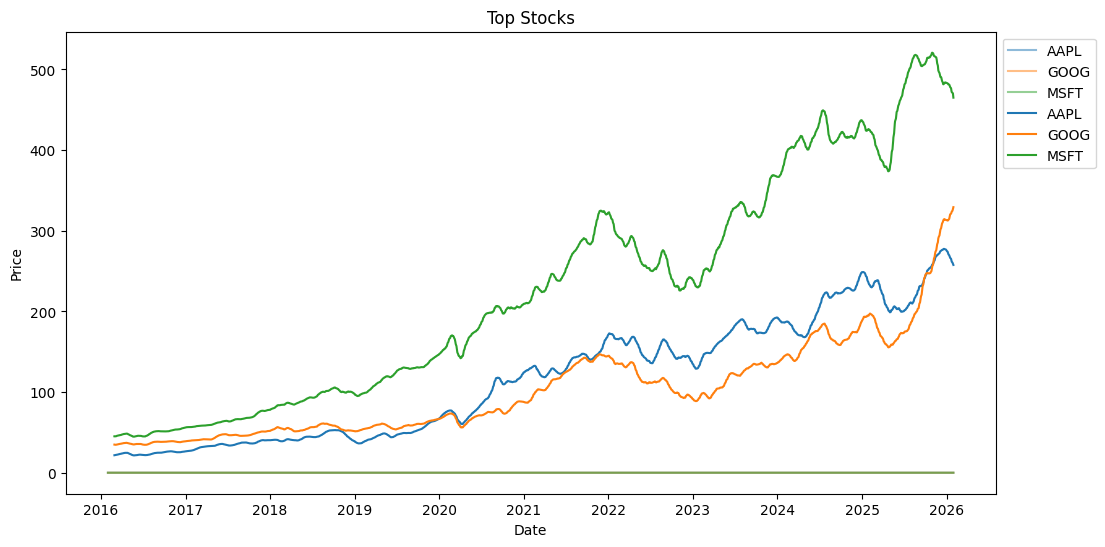

In [29]:
plt.figure(figsize=(12,6))

# Plot actual prices
sns.lineplot(data=df_close, x='Date', y=0, hue='Ticker', alpha=0.5)

# Plot 20-day SMA
sns.lineplot(data=df_close, x='Date', y='sma_20day', hue='Ticker')

plt.ylabel('Price')
plt.title('Top Stocks')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# Plot the stocks with their 20 day moving average

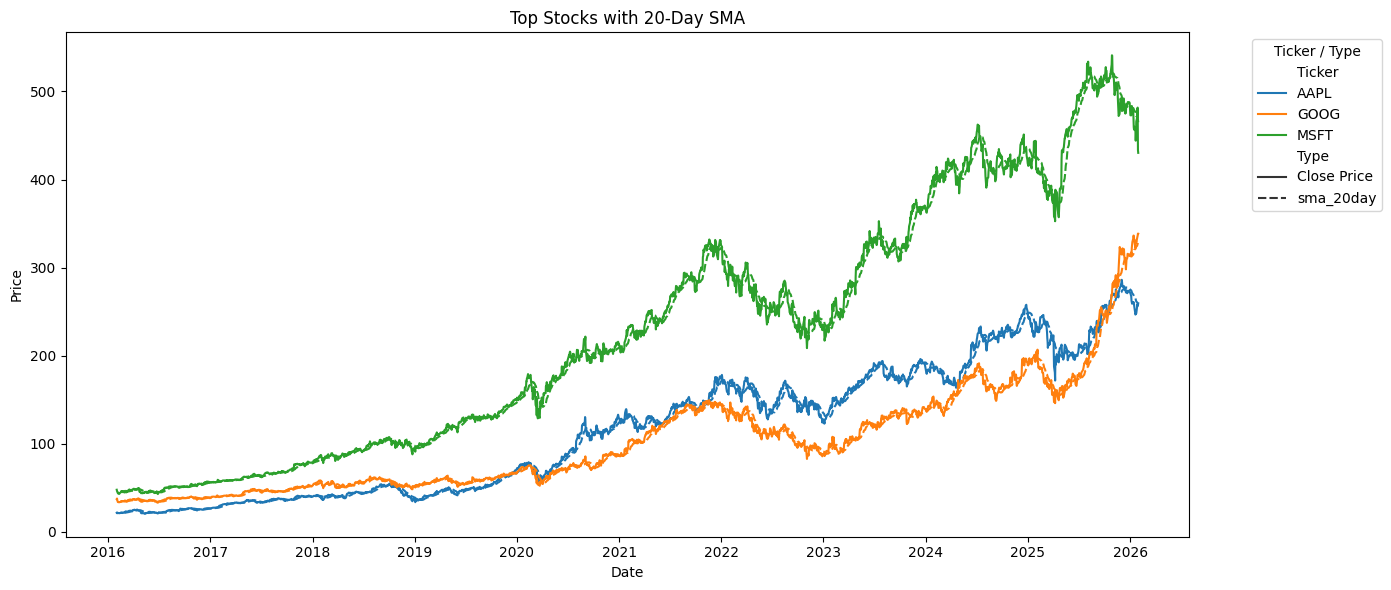

In [31]:
plt.figure(figsize=(14,6))

sns.lineplot(
    data=df_close_melt,
    x='Date',
    y='Price (dollars)',
    hue='Ticker',
    style='Type',   # differentiates Close vs SMA
    palette='tab10'
)

plt.title('Top Stocks with 20-Day SMA')
plt.ylabel('Price')
plt.xlabel('Date')
plt.legend(title='Ticker / Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Predict Apple with Prophet

In [33]:
# Filter for AAPL
aapl = df_close[df_close['Ticker'] == 'AAPL'][['Date', 'Close Price']].copy()
aapl.rename(columns={'Date': 'ds', 'Close Price': 'y'}, inplace=True)


In [102]:
# Initialize model
model = Prophet(daily_seasonality=True)
model.fit(aapl)


16:42:09 - cmdstanpy - INFO - Chain [1] start processing
16:42:10 - cmdstanpy - INFO - Chain [1] done processing


             ds        yhat  yhat_lower  yhat_upper
2610 2026-05-06  257.355575  244.529144  271.031184
2611 2026-05-07  257.307854  244.918109  271.123314
2612 2026-05-08  257.491194  244.357868  269.926803
2613 2026-05-09  257.187496  244.363486  270.177080
2614 2026-05-10  257.221862  244.242707  270.090570


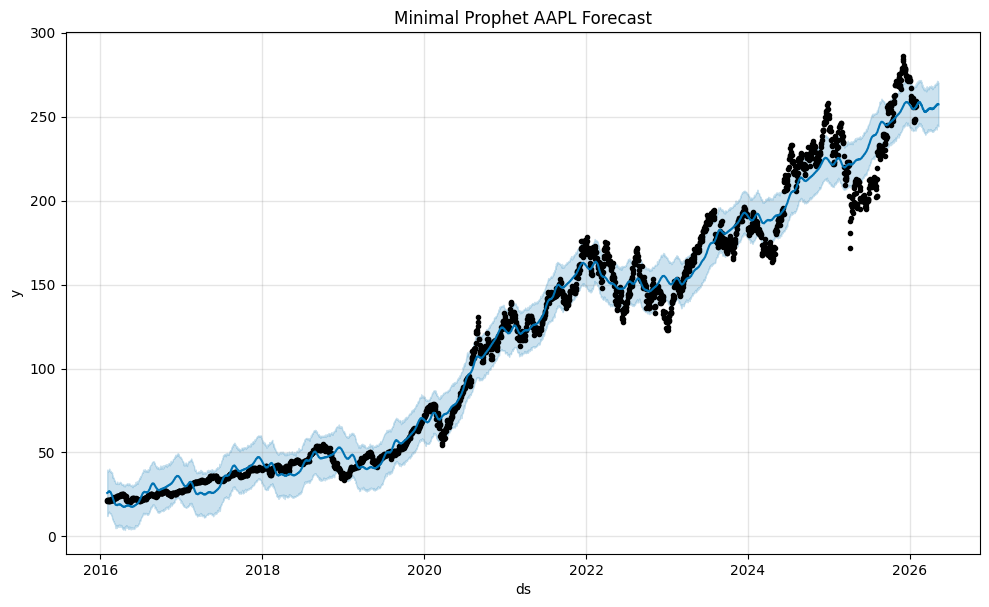

In [104]:
# --- Step 3: Create future dataframe (10 days ahead) ---
future = model.make_future_dataframe(periods=100)

# --- Step 4: Predict ---
forecast = model.predict(future)

# --- Step 5: Inspect results ---
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# --- Step 6: Optional: plot forecast ---
fig1 = model.plot(forecast)
plt.title("Minimal Prophet AAPL Forecast")
plt.show()

In [105]:
# --- Save the model to disk ---
joblib.dump(model, f"prophet_model_aapl_base_{day}.pkl")
print("Model saved successfully!")

Model saved successfully!


# Optuna and Cross Validation

In [38]:
aapl.head()

,ds,y
0,2016-02-01,21.741968
1,2016-02-02,21.302307
2,2016-02-03,21.723932
3,2016-02-04,21.898487
4,2016-02-05,21.313614


In [ ]:
# Assume aapl = your historical AAPL data with 'ds' and 'y'

def objective(trial):
    changepoint = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
    seasonality = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10)
    
    model = Prophet(
        daily_seasonality=True,
        changepoint_prior_scale=changepoint,
        seasonality_prior_scale=seasonality
    )
    
    model.fit(aapl)
    
    # Prophet cross-validation
    df_cv = cross_validation(model, initial='200 days', period='30 days', horizon='30 days', parallel="threads")
    df_p = performance_metrics(df_cv)
    
    return df_p['rmse'].values[0]  # Minimize RMSE

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)


[I 2026-02-01 15:57:30,943] A new study created in memory with name: no-name-1090da40-3a2a-43ec-8e10-07ca2cc59084
C:\Users\nick\AppData\Local\Temp\ipykernel_2980\640127645.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  changepoint = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
C:\Users\nick\AppData\Local\Temp\ipykernel_2980\640127645.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  seasonality = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10)
15:57:31 - cmdstanpy - INFO - Chain [1] start processing
15:57:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. C

Best params: {'changepoint_prior_scale': 0.48857432662424294, 'seasonality_prior_scale': 0.013345396172128116}
Best RMSE: 12.87254606491137


# Utilize the Best Params

In [94]:
study.best_params

{'changepoint_prior_scale': 0.48857432662424294,
 'seasonality_prior_scale': 0.013345396172128116}

In [99]:
model_aapl_optuna = Prophet(
        daily_seasonality=True, **study.best_params)
    
model_aapl_optuna.fit(aapl)

16:41:46 - cmdstanpy - INFO - Chain [1] start processing
16:41:48 - cmdstanpy - INFO - Chain [1] done processing


             ds        yhat  yhat_lower  yhat_upper
2610 2026-05-06  244.153556  226.215121  261.738189
2611 2026-05-07  244.046939  225.483205  261.928911
2612 2026-05-08  244.198070  226.095135  262.033560
2613 2026-05-09  244.273902  225.806447  262.145623
2614 2026-05-10  244.257490  224.658462  263.538049


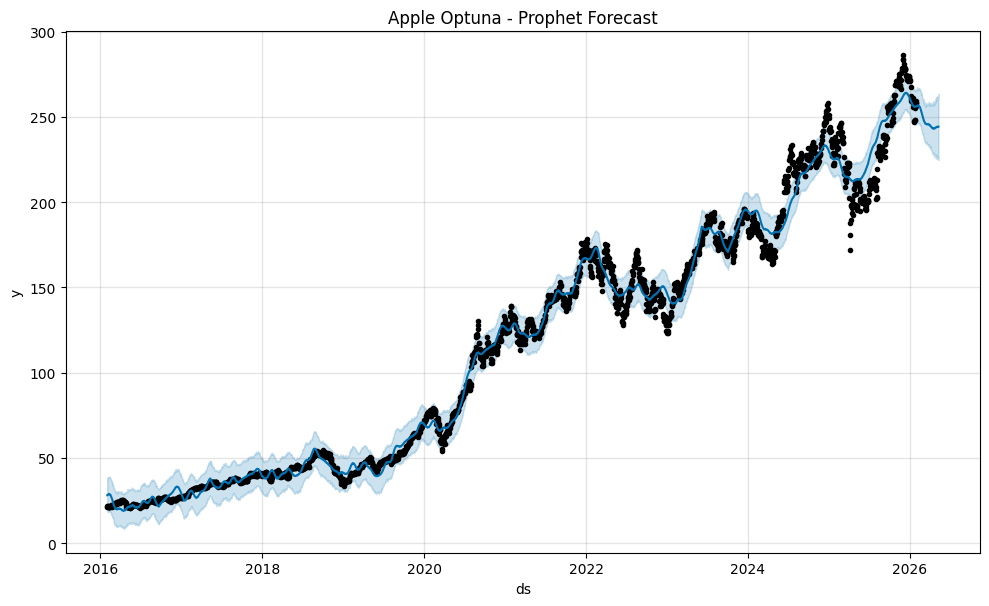

In [100]:
# --- Step 3: Create future dataframe (100 days ahead) ---
future = model_aapl_optuna.make_future_dataframe(periods=100)

# --- Step 4: Predict ---
forecast = model_aapl_optuna.predict(future)

# --- Step 5: Inspect results ---
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# --- Step 6: Optional: plot forecast ---
fig1 = model_aapl_optuna.plot(forecast)
plt.title("Apple Optuna - Prophet Forecast")
plt.show()

In [101]:
# --- Save the model to disk ---
joblib.dump(model_aapl_optuna, f"prophet_model_aapl_{day}.pkl")
print("Model saved successfully!")

Model saved successfully!


# Isolate the future price only

In [53]:
future_data = forecast[forecast['ds'] > pd.Timestamp.now()].copy()

future_data.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2517,2026-02-02,252.765149,246.066102,266.477375,252.765149,252.765149,3.715314,3.715314,3.715314,-0.448182,...,0.101274,0.101274,0.101274,4.062222,4.062222,4.062222,0.0,0.0,0.0,256.480464
2518,2026-02-03,252.849565,246.933795,265.531907,252.849565,252.849565,3.638780,3.638780,3.638780,-0.448182,...,0.029128,0.029128,0.029128,4.057834,4.057834,4.057834,0.0,0.0,0.0,256.488345
2519,2026-02-04,252.933980,246.913370,266.785854,252.933980,252.933980,3.548551,3.548551,3.548551,-0.448182,...,-0.047808,-0.047808,-0.047808,4.044541,4.044541,4.044541,0.0,0.0,0.0,256.482532
2520,2026-02-05,253.018396,246.367585,266.347567,253.018396,253.018396,3.400817,3.400817,3.400817,-0.448182,...,-0.169412,-0.169412,-0.169412,4.018410,4.018410,4.018410,0.0,0.0,0.0,256.419212
2521,2026-02-06,253.102811,246.825006,267.248252,253.102811,253.102811,3.504320,3.504320,3.504320,-0.448182,...,-0.023062,-0.023062,-0.023062,3.975564,3.975564,3.975564,0.0,0.0,0.0,256.607131


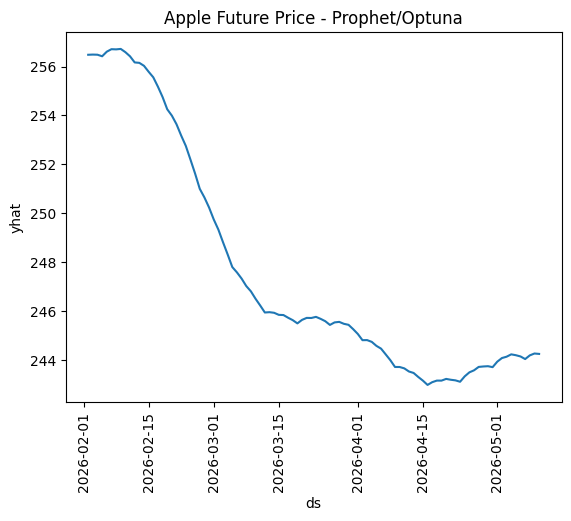

In [57]:
# Show future predictions isolated
sns.lineplot(future_data, x='ds', y='yhat')
plt.xticks(rotation=90)
plt.title('Apple Future Price - Prophet/Optuna')
plt.show();

In [66]:
import yfinance as yf

# Pull historical Bitcoin data
btc = yf.download("BTC-USD", period="20y", interval="1d")
print(btc.head())


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker         BTC-USD     BTC-USD     BTC-USD     BTC-USD   BTC-USD
Date                                                                
2014-09-17  457.334015  468.174011  452.421997  465.864014  21056800
2014-09-18  424.440002  456.859985  413.104004  456.859985  34483200
2014-09-19  394.795990  427.834991  384.532013  424.102997  37919700
2014-09-20  408.903992  423.295990  389.882996  394.673004  36863600
2014-09-21  398.821014  412.425995  393.181000  408.084991  26580100


In [67]:
btc_df = np.round(btc.unstack().reset_index().rename(columns={0:'Price Dollars', 'Price':'Data Type'}),2).copy()

btc_df.head()

,Data Type,Ticker,Date,Price Dollars
0,Close,BTC-USD,2014-09-17,457.33
1,Close,BTC-USD,2014-09-18,424.44
2,Close,BTC-USD,2014-09-19,394.80
3,Close,BTC-USD,2014-09-20,408.90
4,Close,BTC-USD,2014-09-21,398.82


In [68]:
btc_df_close = btc_df[btc_df['Data Type'] == 'Close'].copy()

In [70]:
btc_prophet = btc_df_close[['Date','Price Dollars']].rename(columns={'Date':'ds', 'Price Dollars':'y'})

# Bitcoin Prophet Model

16:35:10 - cmdstanpy - INFO - Chain [1] start processing
16:35:11 - cmdstanpy - INFO - Chain [1] done processing


             ds           yhat     yhat_lower     yhat_upper
4251 2026-05-09  129686.443590  121033.291368  138544.363729
4252 2026-05-10  129784.017759  121409.421756  138281.522807
4253 2026-05-11  129771.375122  121024.905381  138519.027010
4254 2026-05-12  129799.831184  120945.988666  138864.301743
4255 2026-05-13  129910.698796  121289.684618  138709.325955


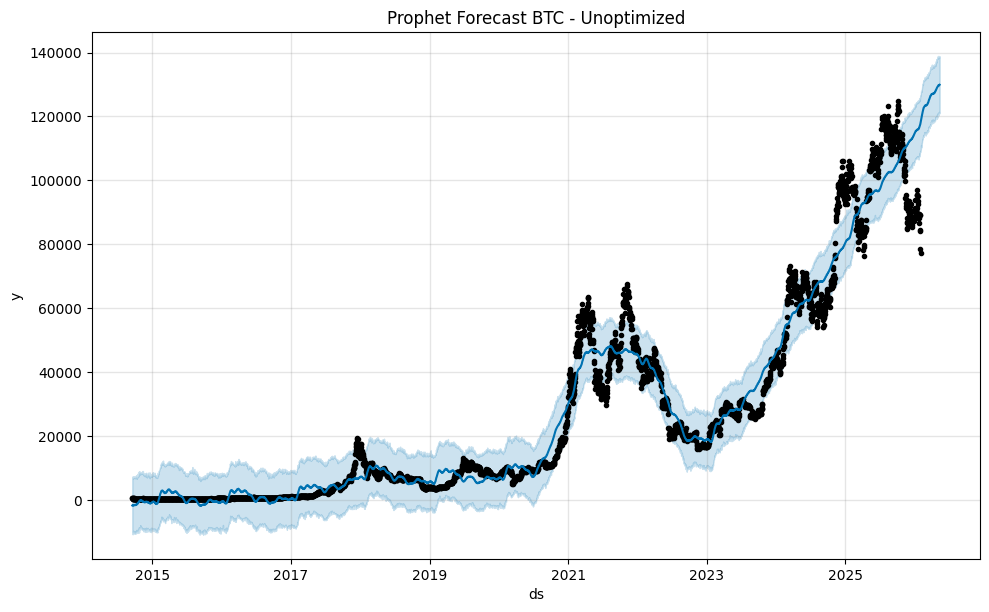

In [79]:
# Initialize model
model_btc = Prophet(daily_seasonality=True)
model_btc.fit(btc_prophet)

# --- Step 3: Create future_btc dataframe (100 days ahead) ---
future_btc = model_btc.make_future_dataframe(periods=100)

# --- Step 4: Predict ---
forecast_btc = model_btc.predict(future_btc)

# --- Step 5: Inspect results ---
print(forecast_btc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# --- Step 6: Optional: plot forecast_btc ---
fig1 = model_btc.plot(forecast_btc)
plt.title("Prophet Forecast BTC - Unoptimized")
plt.show()

In [74]:
import optuna
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import pandas as pd

# Assume aapl = your historical AAPL data with 'ds' and 'y'

def objective(trial):
    changepoint = trial.suggest_loguniform('changepoint_prior_scale', 0.001, 0.5)
    seasonality = trial.suggest_loguniform('seasonality_prior_scale', 0.01, 10)
    
    model_btc = Prophet(
        daily_seasonality=True,
        changepoint_prior_scale=changepoint,
        seasonality_prior_scale=seasonality
    )
    
    model_btc.fit(btc_prophet)
    
    # Prophet cross-validation
    df_cv = cross_validation(model_btc, initial='200 days', period='30 days', horizon='30 days', parallel="threads")
    df_p = performance_metrics(df_cv)
    
    return df_p['rmse'].values[0]  # Minimize RMSE

study_btc = optuna.create_study(direction='minimize')
study_btc.optimize(objective, n_trials=20)

print("Best params:", study_btc.best_params)
print("Best RMSE:", study_btc.best_value)

[I 2026-02-01 16:19:30,851] A new study created in memory with name: no-name-496b2a9c-3a5e-4780-8491-76003cd3be4d
16:19:31 - cmdstanpy - INFO - Chain [1] start processing
16:19:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] start processing
16:19:33 - cmdstanpy - INFO - Chain [1] done processing
16:19:33 - cmdstanpy - INFO - Chain [1] don

Best params: {'changepoint_prior_scale': 0.49683784146610244, 'seasonality_prior_scale': 0.13429775452115153}
Best RMSE: 9472.501613607245


16:34:52 - cmdstanpy - INFO - Chain [1] start processing
16:34:54 - cmdstanpy - INFO - Chain [1] done processing


             ds           yhat     yhat_lower     yhat_upper
4251 2026-05-09  130236.146261  121403.744613  139536.250559
4252 2026-05-10  130345.195814  120740.507334  138586.514314
4253 2026-05-11  130345.784863  121765.717320  139526.067267
4254 2026-05-12  130383.657847  120744.099363  139872.604306
4255 2026-05-13  130500.072554  121420.523240  139808.039788


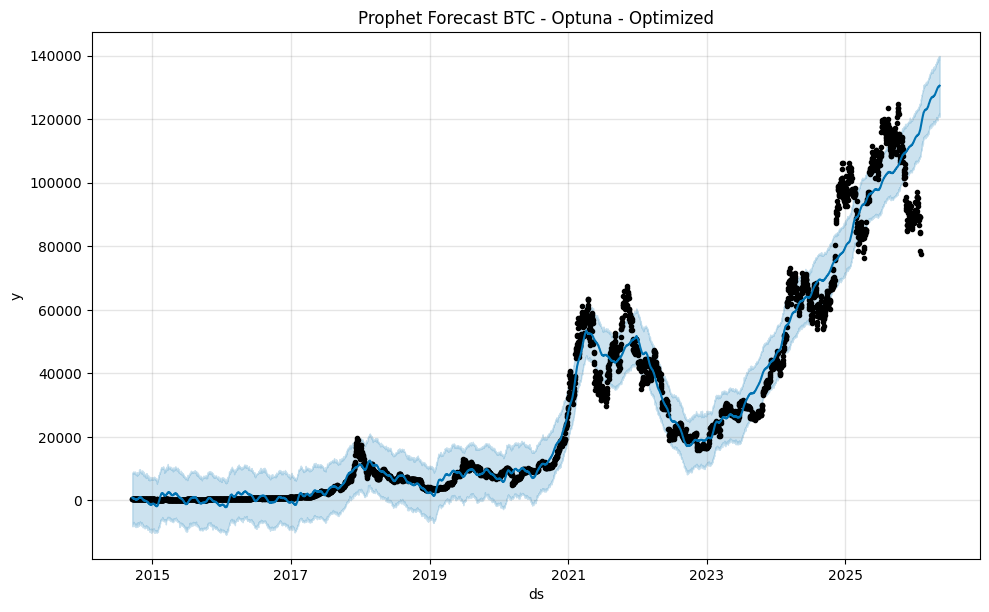

In [78]:
# Initialize model
model_btc_optuna_best = Prophet(daily_seasonality=True, **study_btc.best_params)
model_btc_optuna_best.fit(btc_prophet)

# --- Step 3: Create future_btc dataframe (100 days ahead) ---
future_btc = model_btc_optuna_best.make_future_dataframe(periods=100)

# --- Step 4: Predict ---
forecast_btc = model_btc_optuna_best.predict(future_btc)

# --- Step 5: Inspect results ---
print(forecast_btc[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# --- Step 6: Optional: plot forecast_btc ---
fig1 = model_btc_optuna_best.plot(forecast_btc)
plt.title("Prophet Forecast BTC - Optuna - Optimized")
plt.show()

In [ ]:
# --- Save the model to disk ---
joblib.dump(model_btc_optuna_best, f"prophet_model_btc_{day}.pkl")
print("Model saved successfully!")


Model saved successfully!


In [88]:
# --- Later: load the model ---
loaded_model = joblib.load(r"prophet_model_btc_2026-02-01.pkl")

In [91]:
# --- Make predictions ---
future = loaded_model.make_future_dataframe(periods=10)
forecast = loaded_model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15))

             ds           yhat     yhat_lower     yhat_upper
4151 2026-01-28  116181.295012  108168.552481  124192.001328
4152 2026-01-29  116287.293844  107953.253167  124005.120203
4153 2026-01-30  116506.234028  108529.686671  124465.650153
4154 2026-01-31  116741.910472  108784.813120  124536.121655
4155 2026-02-02  117347.240209  109062.968897  125751.492240
4156 2026-02-03  117664.856414  109785.930014  126066.799713
4157 2026-02-04  118077.151612  110312.550758  126161.406193
4158 2026-02-05  118294.089399  110644.841498  126347.156299
4159 2026-02-06  118609.801216  110826.632484  126346.254430
4160 2026-02-07  118925.835318  110678.858536  126841.548021
4161 2026-02-08  119332.965611  111588.592611  127587.239710
4162 2026-02-09  119635.427230  112027.979965  127936.628851
4163 2026-02-10  119974.373694  111978.762414  128070.865013
4164 2026-02-11  120386.508461  112227.777489  128823.708488
4165 2026-02-12  120581.680874  112999.260815  128909.156885
